In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact

import pydicom
import scipy.ndimage
# import gdcm

import glob

from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.morphology import disk, opening, closing
from tqdm import tqdm

from IPython.display import HTML
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os
from pathlib import Path
import pydicom

In [2]:
# Function to load and sort DICOM slices robustly
def load_scans(dcm_path):
    # List all .dcm files in the directory
    files = [os.path.join(dcm_path, f) for f in os.listdir(dcm_path) if f.lower().endswith('.dcm')]
    
    # Read only DICOMs that contain pixel data (skip reports, RTSTRUCT, etc.)
    slices = []
    for f in files:
        ds = pydicom.dcmread(f)
        if hasattr(ds, "PixelData"):
            slices.append(ds)

    # Define a safe sort key
    def sort_key(ds):
        if hasattr(ds, "ImagePositionPatient") and ds.ImagePositionPatient is not None:
            return float(ds.ImagePositionPatient[2])
        elif hasattr(ds, "SliceLocation"):
            return float(ds.SliceLocation)
        elif hasattr(ds, "InstanceNumber"):
            return int(ds.InstanceNumber)
        else:
            return 0  # fallback if nothing is available

    # Sort slices
    slices.sort(key=sort_key)

    return slices


root = Path(r"/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE")

# For testing: set to a patient ID or None for all
test_patient = None  # e.g., "ID0001"

all_series = []
for patient in sorted(os.listdir(root)):
    
    if test_patient and patient != test_patient:
        continue
    patient_path = root / patient
    if not patient_path.is_dir():
        continue

    # Each subfolder is a scan date (baseline or follow-up)
    for date_folder in sorted(os.listdir(patient_path)):
        date_path = patient_path / date_folder
        if not date_path.is_dir():
            continue


        # Each date folder has one or more series folders
        for series_folder in sorted(os.listdir(date_path)):
            series_path = date_path / series_folder
            if not series_path.is_dir():
                continue

            # Collect all DICOM files in this series
            dicoms = [f for f in series_path.iterdir() if f.suffix.lower() == ".dcm"]
            if dicoms:
                all_series.append({
                    "patient_id": patient,
                    "scan_date": date_folder,
                    "series_path": series_path,
                    "dicom_files": dicoms
                })

print(f"Found {len(all_series)} series")
print("Example:", all_series[4]["series_path"] if all_series else "No series found")
series_path = all_series[4]["series_path"]
scans = load_scans(series_path)
print(f"Loaded {len(scans)} DICOM slices.")
print(scans[2])  # Print the first slice's metadata for verification




Found 142 series
Example: /home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/868819/baseline_1957-10-21/1.2.840.113619.2.55.3.1024080006.789.1477262527.298
Loaded 241 DICOM slices.
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.55.3.1024080006.789.1477262527.299.239
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.214.1
(0002, 0013) Implementation Version Name         SH: '1.2.0.0'
(0002, 0016) Source Application Entity Title     AE: 'VIDA Lambda Anonymizer'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: ['ISO 2022 IR 13', 'ISO 2022 IR 87']
(0008, 0008) Image Type     

In [4]:
import os

patients_root = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN"

# Count only directories (ignore files)
patient_folders = [
    f for f in os.listdir(patients_root)
    if os.path.isdir(os.path.join(patients_root, f))
]

print(f"Total number of patient folders: {len(patient_folders)}")
print("Example patient folders:", patient_folders[:10])  # show first 10


Total number of patient folders: 686
Example patient folders: ['1001326', '298078', '208368', '727988', '1001092', '772512', '930446', '1006495', '1001040', '1000590']


In [82]:
import pandas as pd

# If all_series is a list of dicts, convert it to a DataFrame
all_series_df = pd.DataFrame(all_series)

num_unique_patients = all_series_df["patient_id"].nunique()
print("Number of unique patients:", num_unique_patients)



Number of unique patients: 686


In [12]:
# # Patients with slice count between 20 and 30 (inclusive)
# find_patients_between_20_30 = number_of_slices[
#     (number_of_slices["NumSlices"] >= 30) & (number_of_slices["NumSlices"] <= 70)
# ]

# print(find_patients_between_20_30)

find_patients_below_30_slices = number_of_slices[number_of_slices["NumSlices"] < 30] 
find_patients_below_30_slices  

# patient_id = "1000699"
# patient_slices = number_of_slices.query("PatientID == @patient_id")
# print(patient_slices)



PatientID BaselineDate                                          SeriesUID  \
2      208368   1953-10-26  1.2.840.113619.2.55.3.1024080006.430.151121708...   
6      930446   1973-10-01  1.2.392.200036.9116.2.6.1.3268.2047398422.1499...   
12     164772   1940-11-11  1.2.840.113619.2.55.3.1024080006.536.139079992...   
19     927346   1944-11-06  1.2.840.113619.2.55.3.1024080006.109.141712823...   
21     312980   1963-10-14  1.2.840.113619.2.55.3.1024080006.113.140805618...   
..        ...          ...                                                ...   
667    684240   1954-10-25  1.2.840.113619.2.55.3.1024080006.527.153065811...   
668    567609   1960-10-17  1.2.840.113619.2.55.3.1024080006.320.142619985...   
682    196805   1975-09-29  1.2.840.113619.2.55.3.1024080006.220.142257200...   
684    770462   1966-10-10  1.2.840.113619.2.55.3.1024080006.223.138187583...   
685    278085   1953-10-26  1.2.840.113619.2.55.3.1024080006.729.139639298...   

     NumSlices  
2           18  
6           20  
12          16  
19          20  
21          20  
..         ...  
667         18  
668         18  
682         20  
684         16  
685         17  

[107 rows x 4 columns]

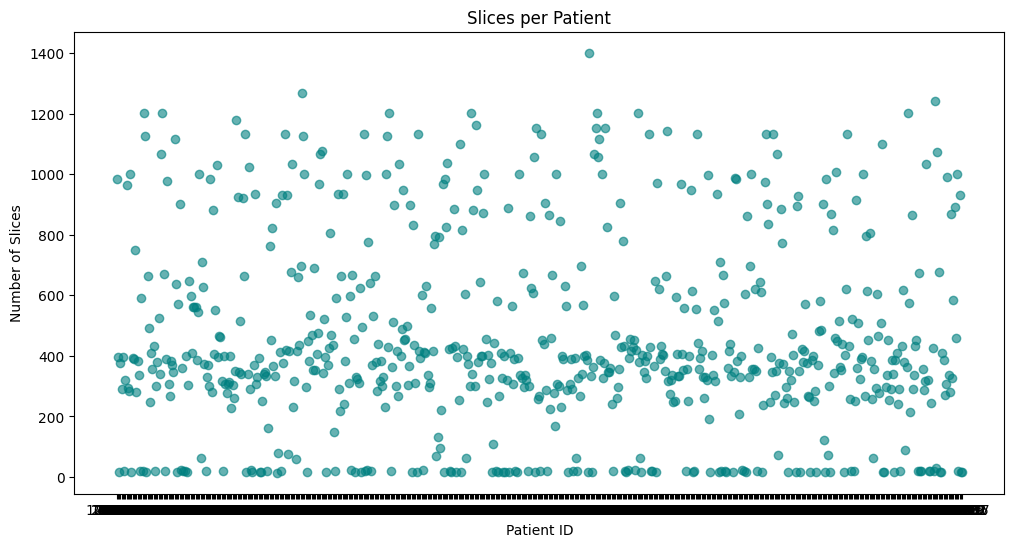

In [18]:
plt.figure(figsize=(12,6))
plt.scatter(number_of_slices['PatientID'], number_of_slices['NumSlices'], alpha=0.6, color='teal')
plt.xlabel("Patient ID")
plt.ylabel("Number of Slices")
plt.title("Slices per Patient")
plt.show()


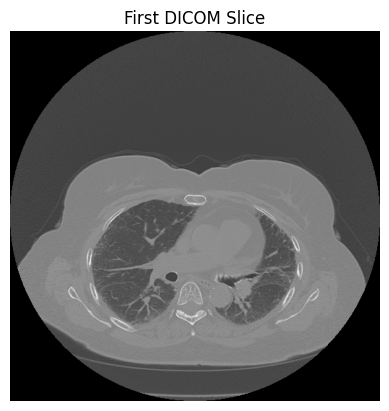

In [10]:
# Visualize a single DICOM slice
import matplotlib.pyplot as plt

# Assuming 'scans' is the sorted list of pydicom dataset objects
first_slice = scans[166]

# Extract pixel array from the first slice
image = first_slice.pixel_array

# Display the image
plt.imshow(image, cmap='gray')
plt.title('First DICOM Slice')
plt.axis('off')
plt.show()


0
1
2
3
4
5
6
7
8
9


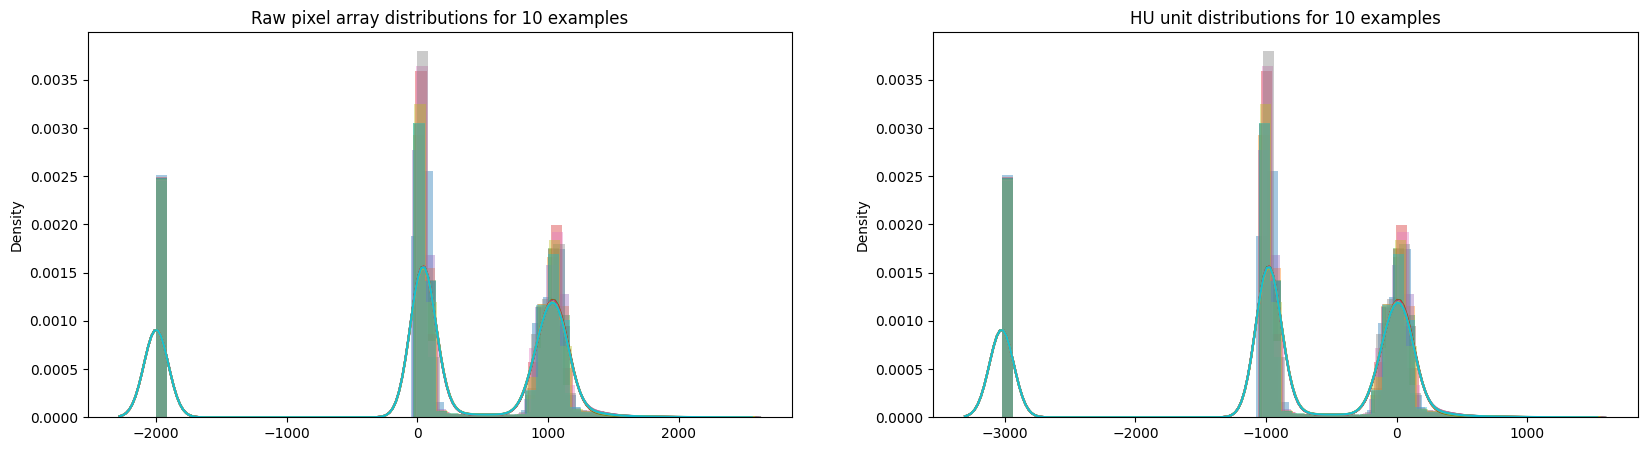

In [3]:
# Plot pixel value distributions for raw and rescaled (HU) values
fig, ax = plt.subplots(1,2,figsize=(20,5))
for n in range(10):
    print(n)
    image = scans[n].pixel_array.flatten()
    rescaled_image = image * scans[n].RescaleSlope + scans[n].RescaleIntercept
    sns.distplot(image.flatten(), ax=ax[0]);
    sns.distplot(rescaled_image.flatten(), ax=ax[1])
ax[0].set_title("Raw pixel array distributions for 10 examples")
ax[1].set_title("HU unit distributions for 10 examples");

In [4]:
# Convert pixel arrays to Hounsfield Units (HU)

def set_outside_scanner_to_air(raw_pixelarrays):
    raw_pixelarrays[raw_pixelarrays <= -1500] = 0
    return raw_pixelarrays

def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)
    print(images)

    #images = set_outside_scanner_to_air(images)
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
     #Clip    
    images = np.clip(images, a_min = -1000,a_max = 200)
    return np.array(images, dtype=np.int16)

# Usage example:
hu_scans = transform_to_hu(scans)
print(hu_scans)  # (num_slices, height, width)
print(np.min(hu_scans), np.max(hu_scans))

[[[-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  ...
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]]

 [[-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  ...
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]]

 [[-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  ...
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]]

 ...

 [[-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  [-2000 -2000 -2000 ... -2000 -2000 -2000]
  ...
  [-2000 -2000 -2000 ... -2000 -2000 -20

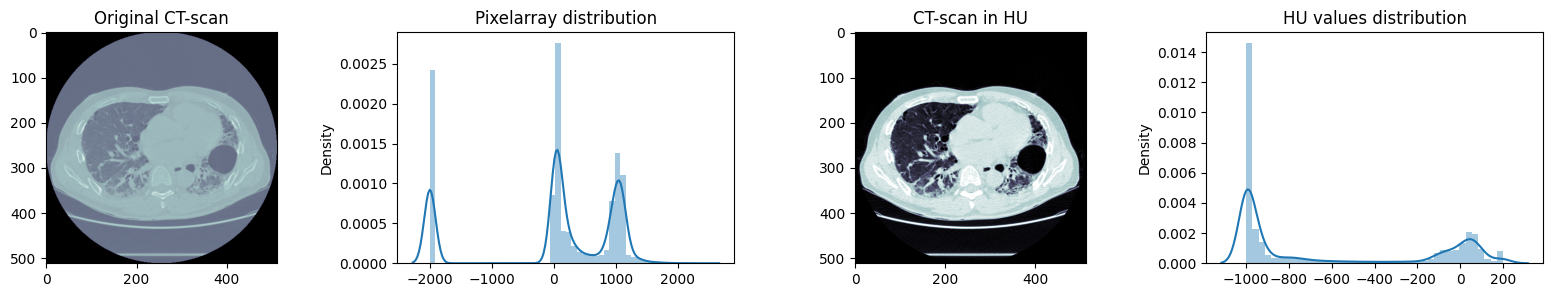

In [5]:
# Plot original and HU-converted images and distributions
fig, ax = plt.subplots(1,4,figsize=(20,3))
ax[0].set_title("Original CT-scan")
ax[0].imshow(scans[120].pixel_array, cmap="bone")
ax[1].set_title("Pixelarray distribution");
sns.distplot(scans[120].pixel_array.flatten(), ax=ax[1]);

ax[2].set_title("CT-scan in HU")
ax[2].imshow(hu_scans[120], cmap="bone")
ax[3].set_title("HU values distribution");
sns.distplot(hu_scans[120].flatten(), ax=ax[3]);

for m in [0,2]:
    ax[m].grid(False)

In [6]:
# Extract and compile scan properties into a DataFrame
def get_window_value(feature):
    if isinstance(feature, pydicom.multival.MultiValue):
        return int(feature[0])  # use built-in int
    else:
        return int(feature)     # use built-in int

pixelspacing_r = []
pixelspacing_c = []
slice_thicknesses = []
patient_id = []
patient_pth = []
row_values = []
column_values = []
window_widths = []
window_levels = []

for series in all_series:
    patient_id.append(series["patient_id"])
    path = str(series["series_path"])
    example_dcm = os.listdir(path)[0]
    patient_pth.append(path)
    dataset = pydicom.dcmread(os.path.join(path, example_dcm))

    window_widths.append(get_window_value(dataset.WindowWidth))
    window_levels.append(get_window_value(dataset.WindowCenter))

    spacing = dataset.PixelSpacing
    slice_thicknesses.append(dataset.SliceThickness)

    row_values.append(dataset.Rows)
    column_values.append(dataset.Columns)
    pixelspacing_r.append(spacing[0])
    pixelspacing_c.append(spacing[1])

    
scan_properties = pd.DataFrame(data=patient_id, columns=["patient"])
scan_properties.loc[:, "rows"] = row_values
scan_properties.loc[:, "columns"] = column_values
scan_properties.loc[:, "area"] = scan_properties["rows"] * scan_properties["columns"]
scan_properties.loc[:, "pixelspacing_r"] = pixelspacing_r
scan_properties.loc[:, "pixelspacing_c"] = pixelspacing_c
scan_properties.loc[:, "pixelspacing_area"] = scan_properties.pixelspacing_r * scan_properties.pixelspacing_c
scan_properties.loc[:, "slice_thickness"] = slice_thicknesses
scan_properties.loc[:, "patient_pth"] = patient_pth
scan_properties.loc[:, "window_width"] = window_widths
scan_properties.loc[:, "window_level"] = window_levels
scan_properties
# patient_id = "906388"
# filtered_rows = scan_properties[scan_properties["patient"] == patient_id]
# print(filtered_rows)



patient  rows  columns    area  pixelspacing_r  pixelspacing_c  \
0     1000182   512      512  262144        0.748047        0.748047   
1     1000205   512      512  262144        0.888672        0.888672   
2     1000207   512      512  262144        0.888672        0.888672   
3     1000260   512      512  262144        0.966797        0.966797   
4     1000262   512      512  262144        0.673828        0.673828   
...       ...   ...      ...     ...             ...             ...   
1030   982799   512      512  262144        0.702000        0.702000   
1031   991765   512      512  262144        0.753906        0.753906   
1032   991765   512      512  262144        0.781250        0.781250   
1033   993354   512      512  262144        0.449219        0.449219   
1034   993354   512      512  262144        0.449219        0.449219   

      pixelspacing_area  slice_thickness  \
0              0.559574             1.25   
1              0.789738             1.00   
2              0.789738             1.00   
3              0.934696             1.00   
4              0.454044             2.00   
...                 ...              ...   
1030           0.492804             1.00   
1031           0.568375             1.50   
1032           0.610352             0.80   
1033           0.201798             1.25   
1034           0.201798             1.25   

                                            patient_pth  window_width  \
0     /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAI...          1500   
1     /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAI...           600   
2     /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAI...           600   
3     /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAI...           360   
4     /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAI...          1600   
...                                                 ...           ...   
1030  /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAI...           300   
1031  /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAI...          1500   
1032  /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAI...          1600   
1033  /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAI...          1200   
1034  /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAI...          1200   

      window_level  
0             -600  
1               60  
2               60  
3               60  
4             -600  
...            ...  
1030            30  
1031          -500  
1032          -600  
1033          -700  
1034          -700  

[1035 rows x 11 columns]

In [ ]:
num_unique_patients = scan_properties["patient"].nunique()
print("Number of unique patients:", num_unique_patients)


Number of unique patients: 686


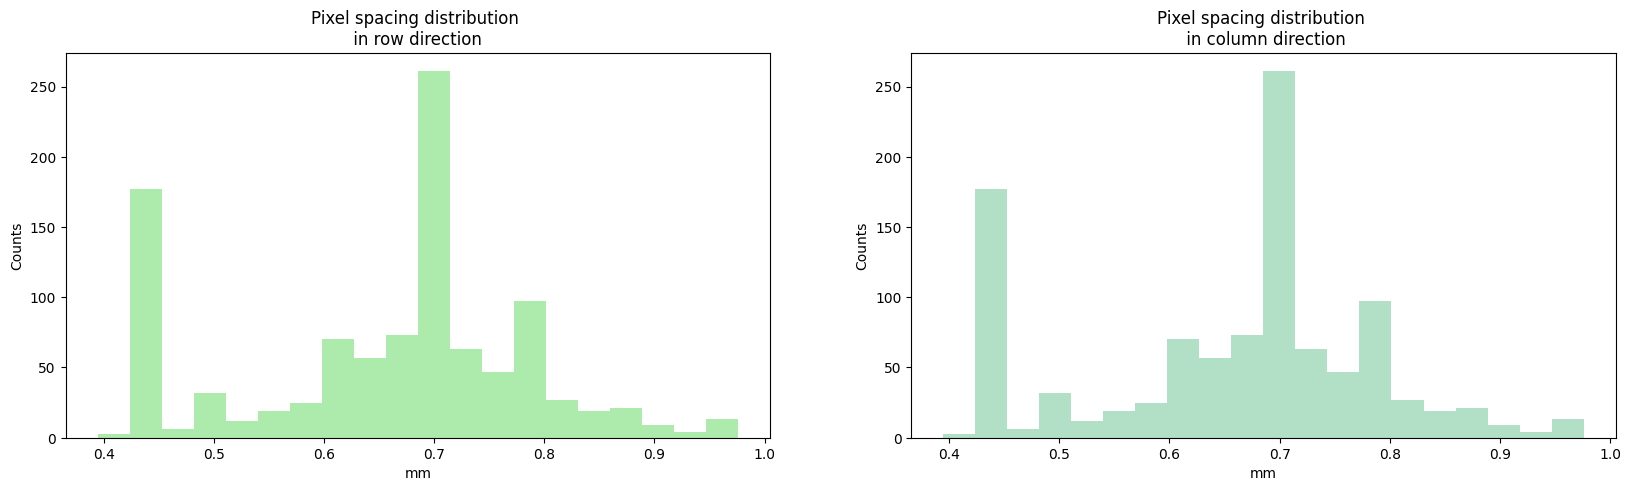

In [7]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(pixelspacing_r, ax=ax[0], color="Limegreen", kde=False)
ax[0].set_title("Pixel spacing distribution \n in row direction ")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("mm")
sns.distplot(pixelspacing_c, ax=ax[1], color="Mediumseagreen", kde=False)
ax[1].set_title("Pixel spacing distribution \n in column direction");
ax[1].set_ylabel("Counts");
ax[1].set_xlabel("mm");

rows  columns
512   512        1002
      532           1
      594           1
768   768          31
dtype: int64


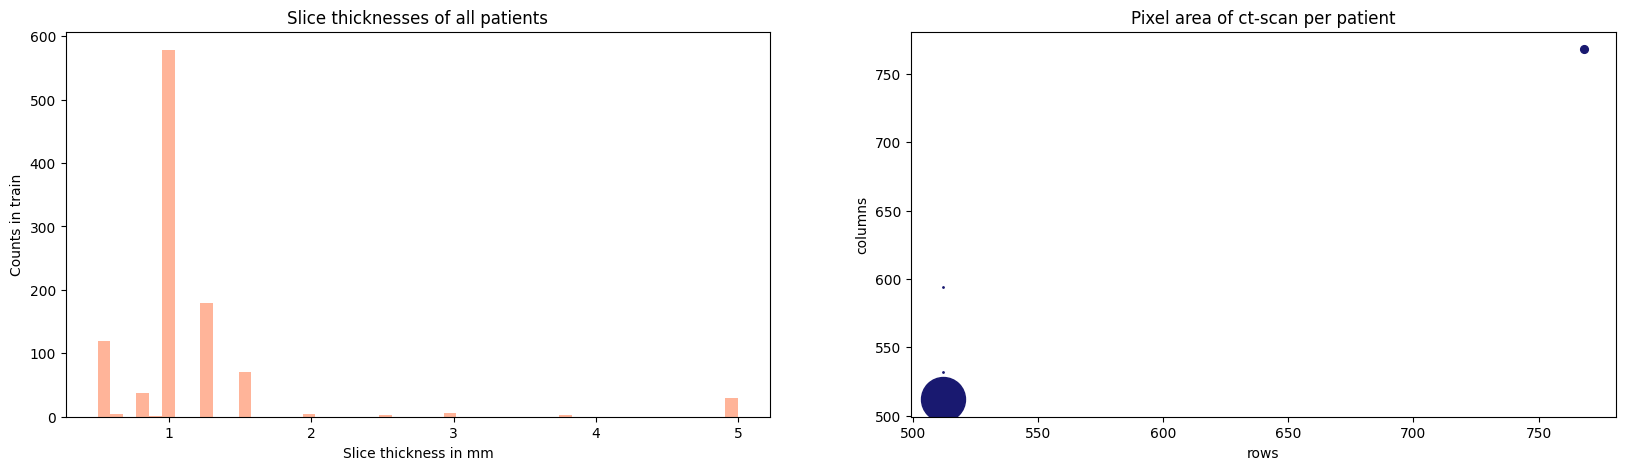

In [8]:
counts = scan_properties.groupby(["rows", "columns"]).size()
print(counts)
counts = counts.unstack()
counts.fillna(0, inplace=True)

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(slice_thicknesses, color="orangered", kde=False, ax=ax[0])
ax[0].set_title("Slice thicknesses of all patients");
ax[0].set_xlabel("Slice thickness in mm")
ax[0].set_ylabel("Counts in train");

for n in counts.index.values:
    for m in counts.columns.values:
        ax[1].scatter(n, m, s=counts.loc[n,m], c="midnightblue")
ax[1].set_xlabel("rows")
ax[1].set_ylabel("columns")
ax[1].set_title("Pixel area of ct-scan per patient");

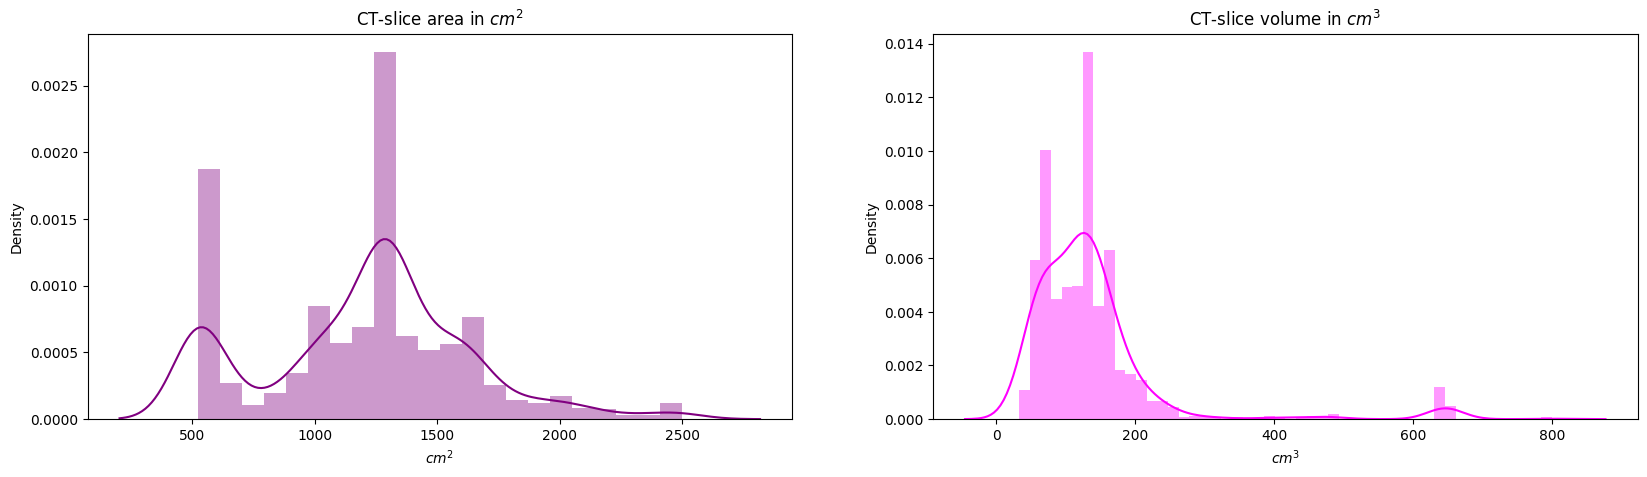

In [9]:
scan_properties["r_distance"] = scan_properties.pixelspacing_r * scan_properties.rows
scan_properties["c_distance"] = scan_properties.pixelspacing_c * scan_properties["columns"]
scan_properties["area_cm2"] = 0.1* scan_properties["r_distance"] * 0.1*scan_properties["c_distance"]
scan_properties["slice_volume_cm3"] = 0.1*scan_properties.slice_thickness * scan_properties.area_cm2

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(scan_properties.area_cm2, ax=ax[0], color="purple")
sns.distplot(scan_properties.slice_volume_cm3, ax=ax[1], color="magenta")
ax[0].set_title("CT-slice area in $cm^{2}$")
ax[1].set_title("CT-slice volume in $cm^{3}$")
ax[0].set_xlabel("$cm^{2}$")
ax[1].set_xlabel("$cm^{3}$");

In [96]:
max_path = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.max()].patient_pth.values[0]
print(max_path)

/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1000699/baseline_1968-01-01/1.2.826.0.1.3680043.10.1218.331126695655900776935042213436613748


/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/631158/baseline_1966-10-10/1.3.6.1.4.1.5962.99.1.1631030776.1265091735.1625128701432.9055.0


[[[ 12   9  14 ...  10  34  52]
  [ 10   7   8 ...  19  37  42]
  [ 11   8   6 ...  23  29  21]
  ...
  [189 168 153 ...  98  95  90]
  [274 236 211 ... 102 107 106]
  [404 363 322 ...  99 106 107]]

 [[ 13  11  11 ...  18  27  38]
  [ 13  10   6 ...  16  23  33]
  [ 15  10   5 ...  14  20  26]
  ...
  [197 187 178 ... 113 108 100]
  [295 263 232 ... 109 109 102]
  [422 374 324 ... 102 105  98]]

 [[ 11  11  12 ...  27  21  21]
  [ 18  14   8 ...  16  14  19]
  [ 25  19   9 ...  10  13  21]
  ...
  [198 191 184 ... 122 121 119]
  [305 279 242 ... 116 115 114]
  [433 392 337 ... 106 101  98]]

 ...

 [[ 22  24  23 ...  23  16  12]
  [ 24  24  23 ...  20  16  15]
  [ 23  24  26 ...  20  18  18]
  ...
  [ 81  84  84 ... 108 116 130]
  [ 91  91  87 ... 124 126 133]
  [104 102  93 ... 141 141 140]]

 [[ 13  12  12 ...  23  24  22]
  [ 19  16  14 ...  22  23  22]
  [ 21  19  18 ...  22  22  22]
  ...
  [ 85  86  85 ... 113 115 117]
  [ 87  87  83 ... 120 120 122]
  [ 97  94  89 ... 134 135 1

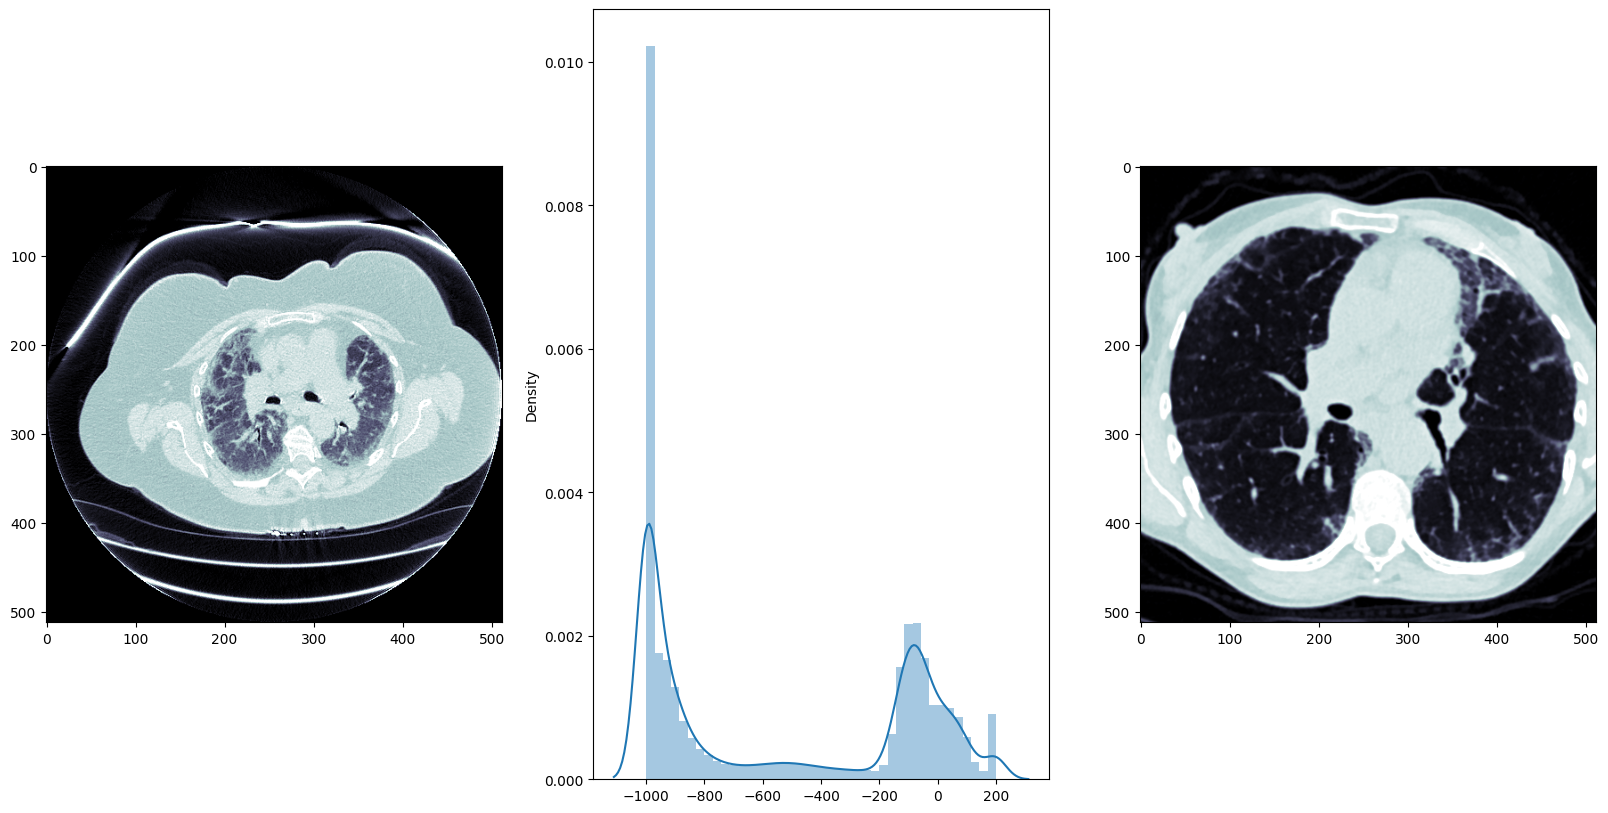

In [ ]:
max_path = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.max()].patient_pth.values[0]
min_path = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.min()].patient_pth.values[0]
print(min_path)

min_scans = load_scans(min_path)
min_hu_scans = transform_to_hu(min_scans)
min_path_window_width = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.min()].window_width.values[0]
print(min_path_window_width)
min_path_window_level = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.min()].window_level.values[0]
print(min_path_window_level)

max_scans = load_scans(max_path)
max_hu_scans = transform_to_hu(max_scans)
max_path_window_width = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.max()].window_width.values[0]
print(max_path_window_width)
max_path_window_level = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.max()].window_level.values[0]
print(max_path_window_level)

background_water_hu_scans = max_hu_scans.copy()
fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(max_hu_scans[int(len(max_hu_scans)/2)], cmap="bone")
sns.distplot(max_hu_scans[int(len(max_hu_scans)/2)].flatten(), ax=ax[1]);
ax[2].imshow(min_hu_scans[int(len(min_hu_scans)/2)], cmap="bone")

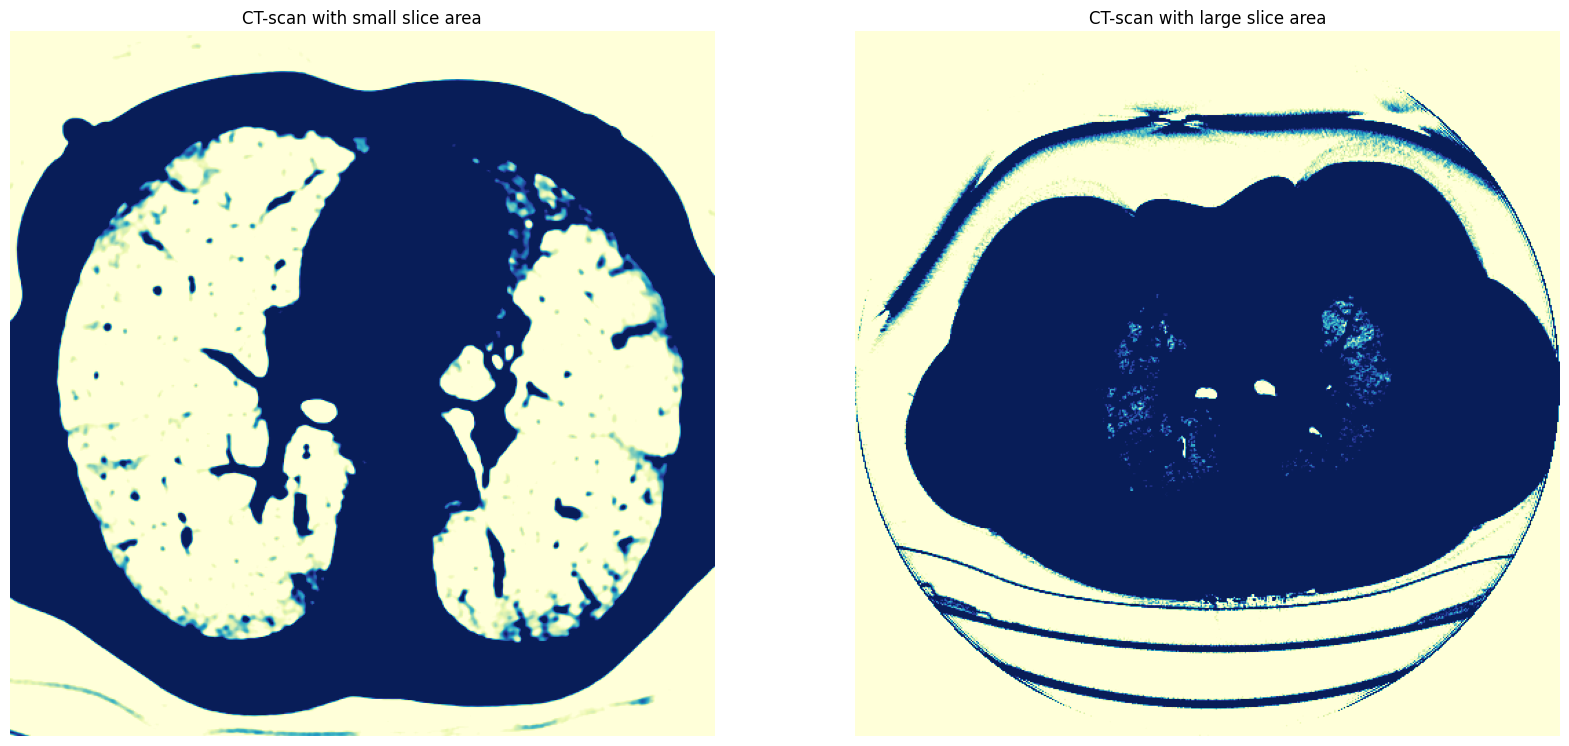

In [27]:
def set_manual_window(hu_image, custom_center, custom_width):
    w_image = hu_image.copy()
    min_value = custom_center - (custom_width/2)
    max_value = custom_center + (custom_width/2)
    w_image[w_image < min_value] = min_value
    w_image[w_image > max_value] = max_value
    return w_image

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(set_manual_window(min_hu_scans[int(len(min_hu_scans)/2)], -700, 255), cmap="YlGnBu")
ax[1].imshow(set_manual_window(max_hu_scans[int(len(max_hu_scans)/2)], -700, 255), cmap="YlGnBu");
ax[0].set_title("CT-scan with small slice area")
ax[1].set_title("CT-scan with large slice area");
for n in range(2):
    ax[n].axis("off")

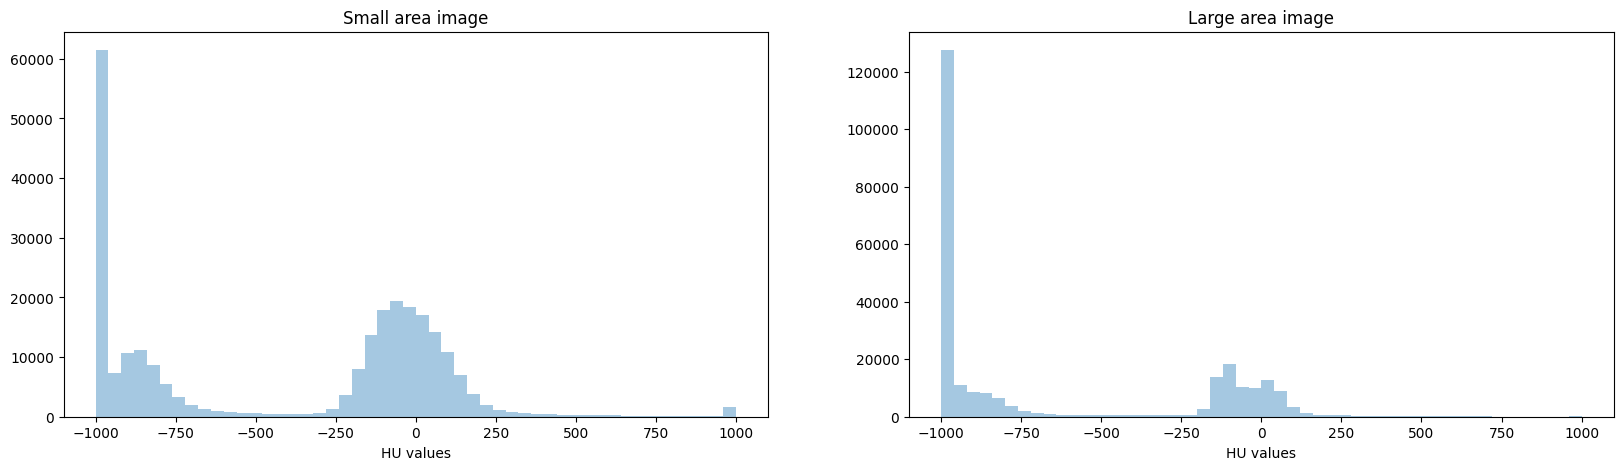

In [23]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(max_hu_scans[int(len(max_hu_scans)/2)].flatten(), kde=False, ax=ax[1])
ax[1].set_title("Large area image")
sns.distplot(min_hu_scans[int(len(min_hu_scans)/2)].flatten(), kde=False, ax=ax[0])
ax[0].set_title("Small area image")
ax[0].set_xlabel("HU values")
ax[1].set_xlabel("HU values");

In [28]:
max_path = scan_properties[
    scan_properties.slice_volume_cm3 == scan_properties.slice_volume_cm3.max()].patient_pth.values[0]
min_path = scan_properties[
    scan_properties.slice_volume_cm3 == scan_properties.slice_volume_cm3.min()].patient_pth.values[0]

min_scans = load_scans(min_path)
min_hu_scans = transform_to_hu(min_scans)
slice_thickness = float(min_scans[0].SliceThickness)
pixel_spacing = [float(sp) for sp in min_scans[0].PixelSpacing]  # [row_spacing, col_spacing]
print("Slice thickness (z) in mm:", slice_thickness)
print("Pixel spacing (y, x) in mm:", pixel_spacing)

max_scans = load_scans(max_path)
max_hu_scans = transform_to_hu(max_scans)

[[[-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  ...
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]]

 [[-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  ...
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]]

 [[-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  ...
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]]

 ...

 [[-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  ...
  [-2048 -2048 -2048 ... -2048 -2048 -20

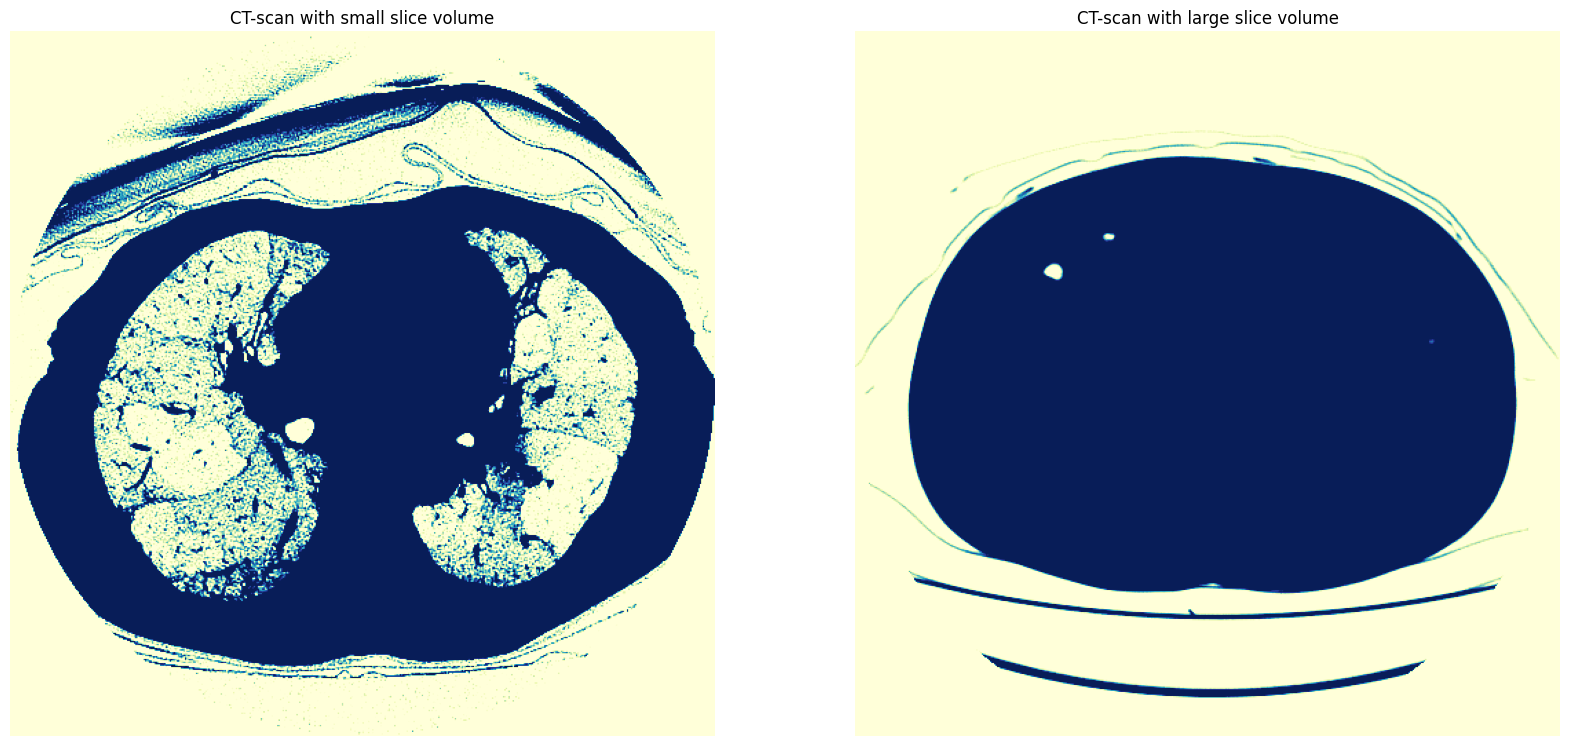

In [29]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(set_manual_window(min_hu_scans[int(len(min_hu_scans)/2)], -700, 255), cmap="YlGnBu")
ax[1].imshow(set_manual_window(max_hu_scans[int(len(max_hu_scans)/2)], -700, 255), cmap="YlGnBu");
ax[0].set_title("CT-scan with small slice volume")
ax[1].set_title("CT-scan with large slice volume");
for n in range(2):
    ax[n].axis("off")

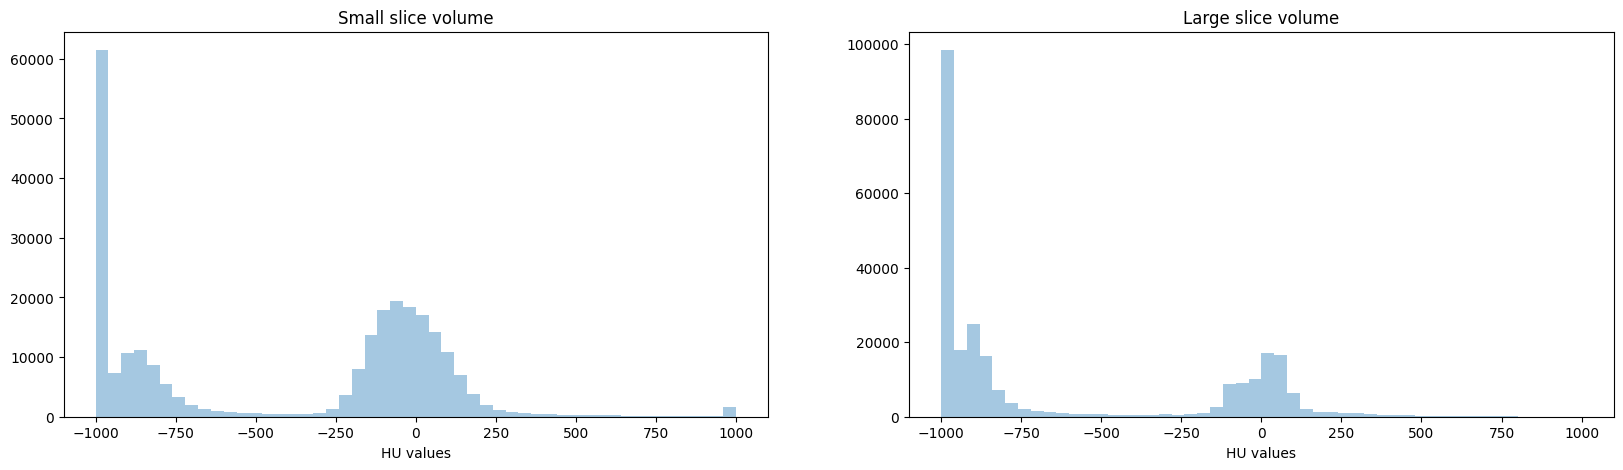

In [26]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(max_hu_scans[int(len(max_hu_scans)/2)].flatten(), kde=False, ax=ax[1])
ax[1].set_title("Large slice volume")
sns.distplot(min_hu_scans[int(len(min_hu_scans)/2)].flatten(), kde=False, ax=ax[0])
ax[0].set_title("Small slice volume")
ax[0].set_xlabel("HU values")
ax[1].set_xlabel("HU values");

In [6]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

def plot_3d(image, threshold=700, color="navy"):
    # Reorient the scan
    p = image.transpose(2, 1, 0)
    
    # Extract mesh using marching cubes
    verts, faces, _, _ = measure.marching_cubes(p, level=threshold)
    
    # Create plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces], alpha=0.2)
    mesh.set_facecolor(color)
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    plt.show()

# Call it OUTSIDE the function
#plot_3d(max_hu_scans, threshold=-300)


In [28]:
scans = load_scans(all_series[2]["series_path"])
hu_scans = transform_to_hu(scans)

[[[ 32  50  26 ...  35   0   4]
  [ 32  10  59 ...   0  29  50]
  [122   0   0 ...  68  40  23]
  ...
  [ 99 132  46 ...  55   4 169]
  [198 106   0 ... 129   0  23]
  [264   0  62 ...  44  67 262]]

 [[  0   0  20 ...  59   4   4]
  [ 26   6  74 ...  11   0 113]
  [ 66   0   5 ...  72  95  17]
  ...
  [162 121 218 ... 208   0   4]
  [  9 136  98 ... 252 162 106]
  [372 244 173 ... 170  31  93]]

 [[159   1 133 ...  66   0  12]
  [ 67   1   3 ...   0  86  41]
  [  0  11   0 ...  93  58  12]
  ...
  [  8 212 192 ... 220   4  38]
  [193  24   0 ... 326 120  39]
  [  0 151 320 ... 262 134  51]]

 ...

 [[  0  12   0 ...  51  55   0]
  [120  61   3 ...  79  16   0]
  [ 21 134  84 ...  38   0  97]
  ...
  [247 160 176 ... 140 182 104]
  [338 151  77 ...  37 220 341]
  [ 42   1 162 ... 161  59 106]]

 [[  7   0  34 ...  65   0  67]
  [106  18   0 ...  17   0   0]
  [165  93  28 ...  12   0  37]
  ...
  [119   0 270 ... 194  76  84]
  [186  90 249 ... 186 138   0]
  [  0  23  36 ... 165 281 1

In [29]:
#plot_3d(hu_scans, threshold=700)

In [30]:
print(len(max_hu_scans), len(hu_scans))

48 646


In [13]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)
    
    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor)
    
    # recompute the resize factor and spacing such that we match the rounded new shape above
    rounded_resize_factor = new_shape / image.shape
    rounded_new_spacing = spacing / rounded_resize_factor
    
    # zoom with resize factor
    image = scipy.ndimage.interpolation.zoom(image, rounded_resize_factor, mode='nearest')
    
    return image, rounded_new_spacing

img_resampled, spacing = resample(max_hu_scans, max_scans, [1,1,1])
print("Shape before resampling\t", max_hu_scans.shape)
print("Shape after resampling\t", img_resampled.shape)

NameError: name 'max_hu_scans' is not defined

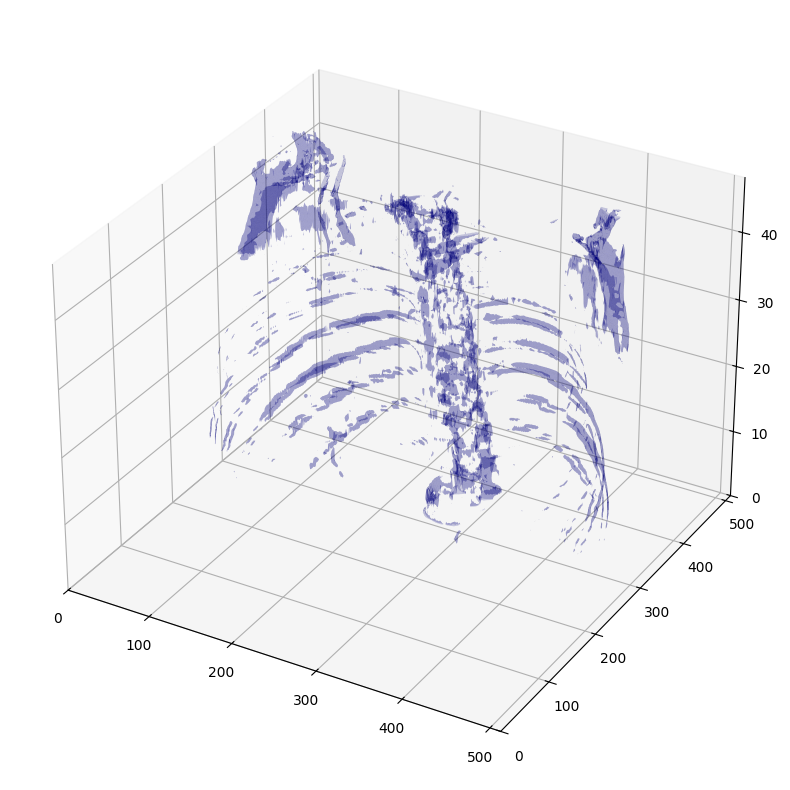

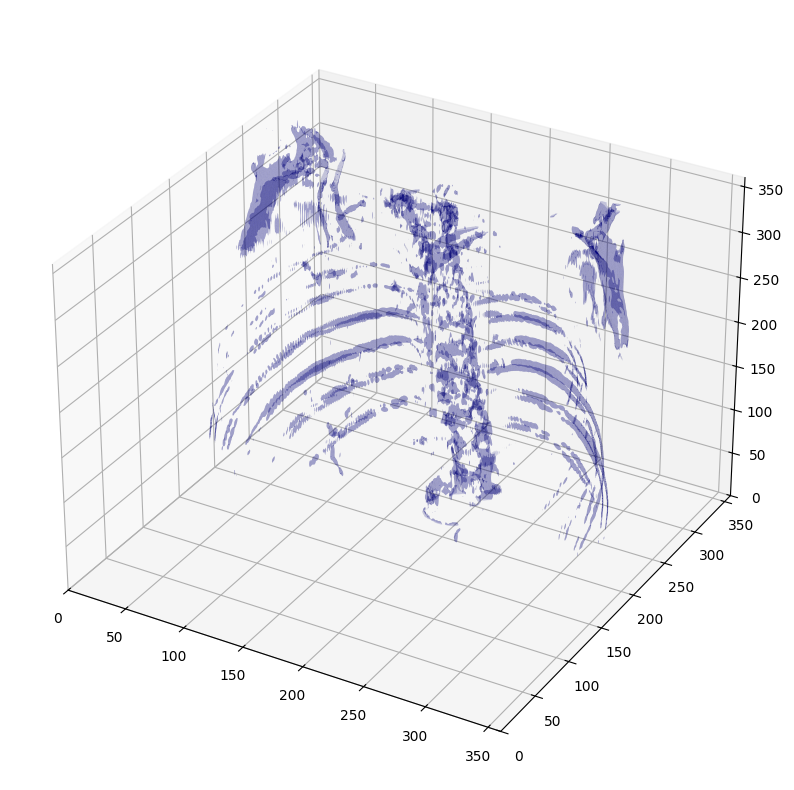

In [32]:
plot_3d(max_hu_scans)
plot_3d(img_resampled)

In [ ]:
import numpy as np
import SimpleITK as sitk

def resample_volume(ct_array, original_spacing, new_spacing=(1, 1, 1), interpolator=sitk.sitkBSpline):
    image_itk = sitk.GetImageFromArray(ct_array)
    # Reverse spacing from (z,y,x) --> (x,y,z)
    image_itk.SetSpacing(tuple(float(s) for s in original_spacing[::-1]))

    original_size = np.array(image_itk.GetSize(), dtype=np.int32)  # already (x, y, z)
    original_spacing = np.array(original_spacing, dtype=np.float64)
    new_spacing = np.array(new_spacing, dtype=np.float64)

    # Calculate new_size in numpy (z, y, x) order, then reverse for SimpleITK
    new_size = np.round(original_size * (original_spacing[::-1] / new_spacing[::-1])).astype(int)

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(tuple(float(s) for s in new_spacing[::-1]))
    resampler.SetSize([int(s) for s in new_size])
    resampler.SetOutputDirection(image_itk.GetDirection())
    resampler.SetOutputOrigin(image_itk.GetOrigin())
    resampler.SetInterpolator(interpolator)

    resampled_itk = resampler.Execute(image_itk)
    resampled_array = sitk.GetArrayFromImage(resampled_itk)
    # resampled_array = sitk.GetArrayFromImage(resampled_itk).astype(np.int16)

    actual_spacing = resampled_itk.GetSpacing()[::-1]  # back to (z, y, x) for numpy

    return resampled_array, actual_spacing

def get_original_spacing(scans):

    slice_thickness = float(scans[0].SliceThickness)
    pixel_spacing = [float(sp) for sp in scans[0].PixelSpacing]  # [row_spacing, col_spacing]

    # Return as (z, y, x)
    return (slice_thickness, pixel_spacing[0], pixel_spacing[1])

# Example usage
spacing = get_original_spacing(max_scans)
print("Original spacing (z, y, x) in mm:", spacing)

resampled_ct, new_spacing = resample_volume(max_hu_scans, spacing)
print("Original shape:", max_hu_scans.shape)
print("Resampled shape:", resampled_ct.shape)
print("New spacing:", new_spacing)
#plot_3d(resampled_ct , threshold=-600)


Original spacing (z, y, x) in mm: (7.5, 0.703125, 0.703125)
Original shape: (48, 512, 512)
Resampled shape: (360, 360, 360)
New spacing: (1.0, 1.0, 1.0)


In [59]:
print("Example:", all_series[0]["series_path"] if all_series else "No series found")
# Step 1: Go up one level (to baseline_1969-10-06)
baseline_folder = os.path.dirname(all_series[0]["series_path"])

# Step 2: Create the "masks" folder inside it
masks_folder = os.path.join(baseline_folder, "masks")
os.makedirs(masks_folder, exist_ok=True)

print(f"Masks folder created at: {masks_folder}")

Example: PATIENTS_DICOM_STRUCTURE/865785/baseline_1969-10-06/1.2.392.200036.9116.2.6.1.3268.2047398422.1583821116.160520
Masks folder created at: PATIENTS_DICOM_STRUCTURE/865785/baseline_1969-10-06/masks


In [35]:
import torch
print(torch.cuda.is_available())  # should be True


True


In [7]:
from lungmask import LMInferer
import SimpleITK as sitk

# inferer = LMInferer(modelname='LTRCLobes', fillmodel='R231')
inferer = LMInferer(modelname="R231CovidWeb")
def get_original_spacing(scans):
    slice_thickness = float(scans[0].SliceThickness)
    pixel_spacing = [float(i) for i in scans[0].PixelSpacing]
    return (slice_thickness, pixel_spacing[0], pixel_spacing[1])  # (z, y, x)

spacing = get_original_spacing(scans)


# Assume hu_scan: your CT scan in HU, shape (z, y, x)
sitk_ct = sitk.GetImageFromArray(hu_scans)
# sitk_ct.SetSpacing(spacing[::-1])  # Set to your actual spacing (x, y, z)
segmentation = inferer.apply(sitk_ct)  # default model is U-net(R231)

# Step 1: Go up one level (to baseline_1969-10-06)
baseline_folder = os.path.dirname(series_path)
print(baseline_folder)
# Step 2: Create the "masks" folder inside it
masks_folder = os.path.join(baseline_folder, "masks")
# if not os.path.exists(masks_folder):
os.makedirs(masks_folder, exist_ok=True)
print(f"Masks folder created at: {masks_folder}")

# Step 3: Example of saving your mask file there
np.savez_compressed(
    os.path.join(masks_folder, "lung_mask1.npz"),
    mask=segmentation,
    spacing=sitk_ct.GetSpacing(),
    origin=sitk_ct.GetOrigin(),
    direction=sitk_ct.GetDirection()
)
print("Mask saved successfully.")



16it [00:05,  2.78it/s]                          

lungmask 2025-09-17 12:31:43 Postprocessing



100%|██████████| 19/19 [00:00<00:00, 38.55it/s]


PATIENTS_DICOM_STRUCTURE/865785/baseline_1969-10-06
Masks folder created at: PATIENTS_DICOM_STRUCTURE/865785/baseline_1969-10-06/masks
Mask saved successfully.


In [37]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))


2.0.1+cu117
11.7
Quadro P5000


In [38]:
!rm -rf /home/pansurya/.local/lib/python3.9/site-packages/torch-*
!rm -rf /home/pansurya/.local/lib/python3.9/site-packages/torchvision-*
!rm -rf /home/pansurya/.local/lib/python3.9/site-packages/torchaudio-*




In [39]:
# print(segmentation.min(), segmentation.max())
# # Combine left and right lungs into one binary mask
# binary_mask = (segmentation > 0).astype(np.uint8)
# print(binary_mask.min(), binary_mask.max())

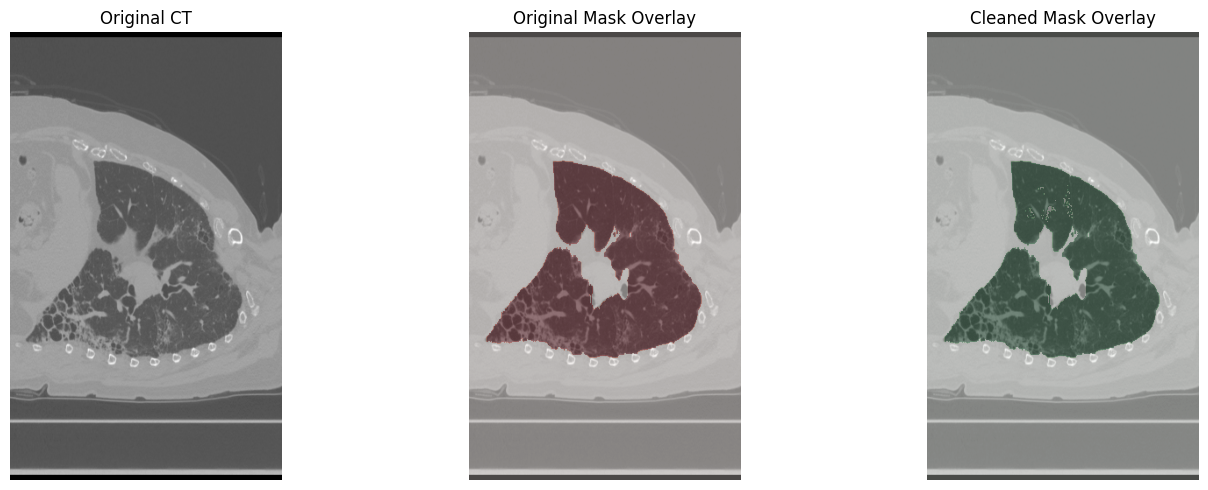

In [13]:
import SimpleITK as sitk
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt

def remove_airways_and_show(ct_path, mask_path, slice_idx=155):
    # Load CT and mask
    ct = sitk.ReadImage(ct_path)
    mask = sitk.ReadImage(mask_path)
    ct_arr = sitk.GetArrayFromImage(ct)
    mask_arr = sitk.GetArrayFromImage(mask)

    # Apply mask to CT
    lung_ct = np.where(mask_arr > 0, ct_arr, 0)

    # Threshold to find airways (very low HU)
    airway_candidates = (lung_ct < -950).astype(np.uint8)

    # Label connected components
    labels = measure.label(airway_candidates, connectivity=3)

    # Assume largest component is airway
    props = measure.regionprops(labels)
    if props:
        largest = max(props, key=lambda x: x.area).label
        airway_mask = (labels == largest).astype(np.uint8)
        cleaned_mask = mask_arr * (1 - airway_mask)
    else:
        cleaned_mask = mask_arr

    # --- Visualization ---
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(ct_arr[slice_idx], cmap='gray')
    axs[0].set_title("Original CT")

    axs[1].imshow(ct_arr[slice_idx], cmap='gray')
    axs[1].imshow(mask_arr[slice_idx], cmap='Reds', alpha=0.3)
    axs[1].set_title("Original Mask Overlay")

    axs[2].imshow(ct_arr[slice_idx], cmap='gray')
    axs[2].imshow(cleaned_mask[slice_idx], cmap='Greens', alpha=0.3)
    axs[2].set_title("Cleaned Mask Overlay")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return cleaned_mask

cleaned = remove_airways_and_show("/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/865785/baseline_1969-10-06/865785_baseline_1969-10-06_NIfTY/865785_baseline_1969-10-06.nii.gz", "/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/865785/baseline_1969-10-06/865785_baseline_1969-10-06_Mask/865785_baseline_1969-10-06_mask.nii.gz", slice_idx=200)



NpzFile '/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/865785/baseline_1969-10-06/masks/lung_mask.npz' with keys: mask, spacing, origin, direction
Mask shape: (310, 512, 512)
Spacing: (1.0, 1.0, 1.0)
Origin: (0.0, 0.0, 0.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


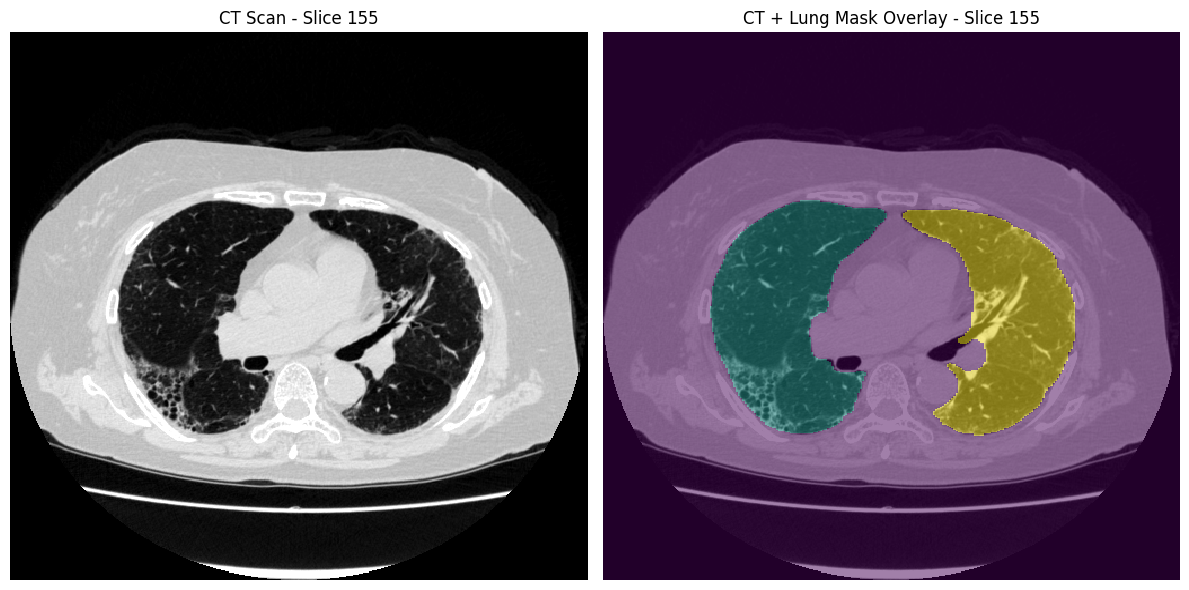

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the .npz file
data = np.load("/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/865785/baseline_1969-10-06/masks/lung_mask.npz")
print(data)  # List all keys in the .npz file
# Access each stored item by its key
mask = data["mask"]           # segmentation array
spacing = tuple(data["spacing"])
origin = tuple(data["origin"])
direction = tuple(data["direction"])

print("Mask shape:", mask.shape)
print("Spacing:", spacing)
print("Origin:", origin)
print("Direction:", direction)

ct_array = hu_scans

# Pick a slice index
slice_idx = ct_array.shape[0] // 2  # middle slice
# slice_idx = 176
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original CT slice
sns.heatmap(ct_array[slice_idx], cmap="gray", cbar=False, ax=axes[0])
axes[0].set_title(f"CT Scan - Slice {slice_idx}")
axes[0].axis("off")

# Mask overlay on CT
sns.heatmap(ct_array[slice_idx], cmap="gray", cbar=False, ax=axes[1])
sns.heatmap(mask[slice_idx], cmap="viridis", alpha=0.5, cbar=False, ax=axes[1])
axes[1].set_title(f"CT + Lung Mask Overlay - Slice {slice_idx}")
axes[1].axis("off")

plt.tight_layout()
plt.show()



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import imageio

# -----------------------------
# Load NIfTI CT scan
# -----------------------------
nifti_path = "/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/868819/baseline_1957-10-21/868819_baseline_1957-10-21_NIfTY/868819_baseline_1957-10-21.nii.gz"
nii_ct = nib.load(nifti_path)
ct_array = nii_ct.get_fdata().astype(np.int16)

# -----------------------------
# Load lung mask (NIfTI)
# -----------------------------
mask_path = "/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/868819/baseline_1957-10-21/868819_baseline_1957-10-21_Mask/868819_baseline_1957-10-21_mask.nii.gz"
nii_mask = nib.load(mask_path)
mask = nii_mask.get_fdata().astype(np.int16)

# -----------------------------
# Sanity check
# -----------------------------
if ct_array.shape != mask.shape:
    raise ValueError("CT and mask shapes differ! Resampling needed.")

# -----------------------------
# Create GIF frames
# -----------------------------
frames = []
for slice_idx in range(ct_array.shape[0]):  # iterate along first axis
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # CT slice
    sns.heatmap(ct_array[slice_idx], cmap="gray", cbar=False, ax=axes[0])
    axes[0].set_title(f"CT Slice {slice_idx}")
    axes[0].axis("off")

    # CT + Mask overlay
    sns.heatmap(ct_array[slice_idx], cmap="gray", cbar=False, ax=axes[1])
    sns.heatmap(mask[slice_idx], cmap="viridis", alpha=0.5, cbar=False, ax=axes[1])
    axes[1].set_title(f"CT + Mask Slice {slice_idx}")
    axes[1].axis("off")

    plt.tight_layout()
    fig.canvas.draw()

    # Convert figure to numpy array
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)

    plt.close(fig)

# -----------------------------
# Save as GIF
# -----------------------------
imageio.mimsave("ct_with_mask_868819.gif", frames, fps=5)
print("✅ GIF saved as ct_with_mask.gif")


/tmp/ipykernel_3049727/1623075285.py:49: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_3049727/1623075285.py:49: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_3049727/1623075285.py:49: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_3049727/1623075285.py:49: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uin

✅ GIF saved as ct_with_mask.gif


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact

# Load your data
data = np.load("/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/865785/baseline_1969-10-06/masks/lung_mask.npz", allow_pickle=True)
mask = data["mask"]
spacing = tuple(data["spacing"])
origin = tuple(data["origin"])
direction = tuple(data["direction"])

ct_array = hu_scans  # your CT scan array

def show_slice(slice_idx):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original CT slice
    sns.heatmap(ct_array[slice_idx], cmap="gray", cbar=False, ax=axes[0])
    axes[0].set_title(f"CT Scan - Slice {slice_idx}")
    axes[0].axis("off")

    # Mask overlay
    sns.heatmap(ct_array[slice_idx], cmap="gray", cbar=False, ax=axes[1])
    sns.heatmap(mask[slice_idx], cmap="viridis", alpha=0.5, cbar=False, ax=axes[1])
    axes[1].set_title(f"CT + Lung Mask Overlay - Slice {slice_idx}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Create slider
interact(show_slice, slice_idx=widgets.IntSlider(min=0, max=ct_array.shape[0]-1, step=1, value=ct_array.shape[0]//2));


UnpicklingError: Failed to interpret file '/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/868819/baseline_1957-10-21/868819_baseline_1957-10-21_Mask/868819_baseline_1957-10-21_mask.nii.gz' as a pickle

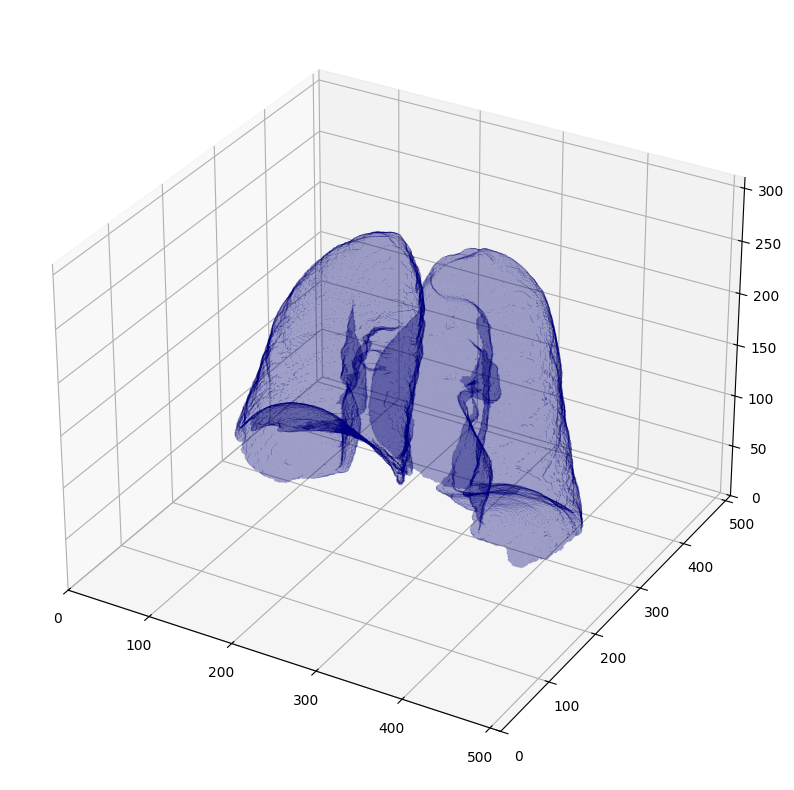

In [15]:
plot_3d(mask, threshold=0.5)

In [6]:
binary_mask = (mask > 0).astype(np.uint8)
print(binary_mask.min(), binary_mask.max())
# Pick a slice index
slice_idx = ct_array.shape[0] // 2  # middle slice
# slice_idx = 400

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original CT slice
sns.heatmap(ct_array[slice_idx], cmap="gray", cbar=False, ax=axes[0])
axes[0].set_title(f"CT Scan - Slice {slice_idx}")
axes[0].axis("off")

# Mask overlay on CT
sns.heatmap(ct_array[slice_idx], cmap="Greens", cbar=False, ax=axes[1])
sns.heatmap(binary_mask[slice_idx]*ct_array[slice_idx], cmap="gray", alpha=0.5, cbar=False, ax=axes[1])
axes[1].set_title(f"CT + Lung Mask Overlay - Slice {slice_idx}")
axes[1].axis("off")

plt.tight_layout()
plt.show()

NameError: name 'mask' is not defined

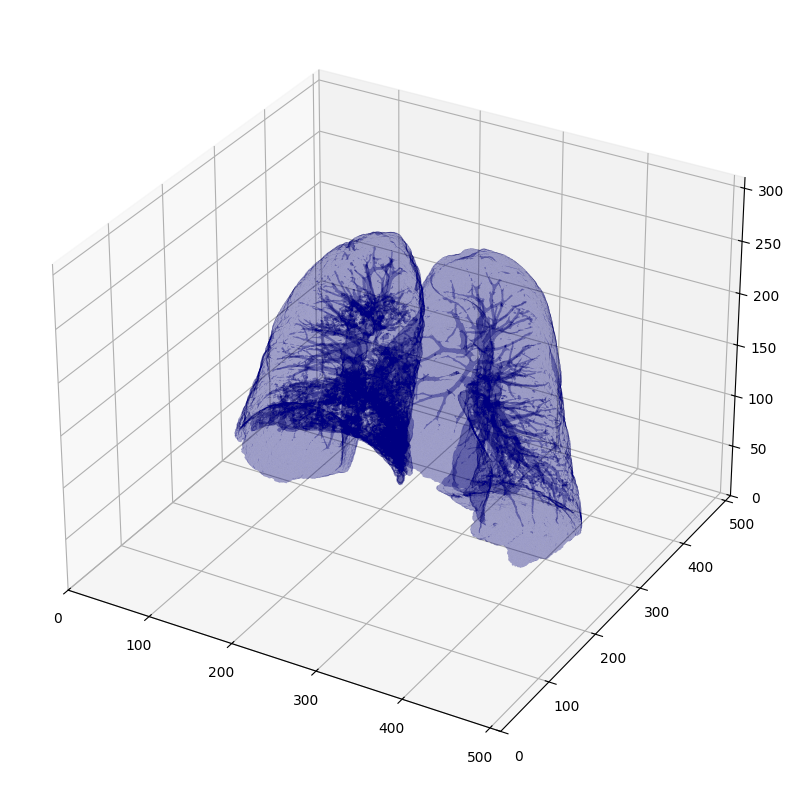

In [18]:
lung_only_ct = ct_array * binary_mask
plot_3d(lung_only_ct, threshold=-300)


In [ ]:
def segment_lung_mask(image):
    segmented = np.zeros(image.shape)   
    
    for n in range(image.shape[0]):
        binary_image = np.array(image[n] > -320, dtype=np.int8)+1
        labels = measure.label(binary_image)
        
        bad_labels = np.unique([labels[0,:], labels[-1,:], labels[:,0], labels[:,-1]])
        for bad_label in bad_labels:
            binary_image[labels == bad_label] = 2
    
        #We have a lot of remaining small signals outside of the lungs that need to be removed.
        #closing is superior to fill_lungs 
        selem = disk(2)
        binary_image = opening(binary_image, selem)
    
        binary_image -= 1 #Make the image actual binary
        binary_image = 1-binary_image # Invert it, lungs are now 1
        
        segmented[n] = binary_image.copy() * image[n]
    
    return segmented

In [27]:
binary_image = np.array((hu_scans[193]>-250), dtype=np.int8)+1
np.unique(binary_image)

array([1, 2], dtype=int8)

In [28]:
labels = measure.label(binary_image)

bad_labels = np.unique([labels[0,:], labels[-1,:], labels[:,0], labels[:,-1]])
binary_image_2 = binary_image.copy()
for bad_label in bad_labels:
    binary_image_2[labels == bad_label] = 2

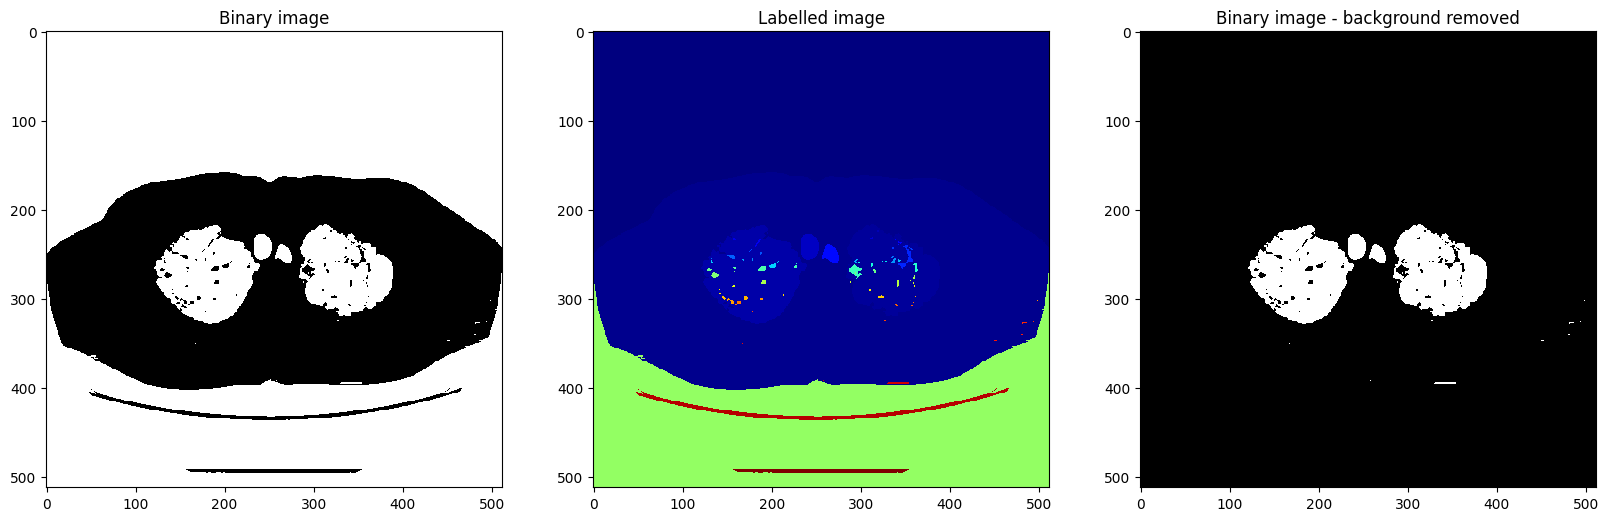

In [29]:
fig, ax = plt.subplots(1,3,figsize=(20,7))
ax[0].imshow(binary_image, cmap="binary", interpolation='nearest')
ax[1].imshow(labels, cmap="jet", interpolation='nearest')
ax[2].imshow(binary_image_2, cmap="binary", interpolation='nearest')

ax[0].set_title("Binary image")
ax[1].set_title("Labelled image");
ax[2].set_title("Binary image - background removed");


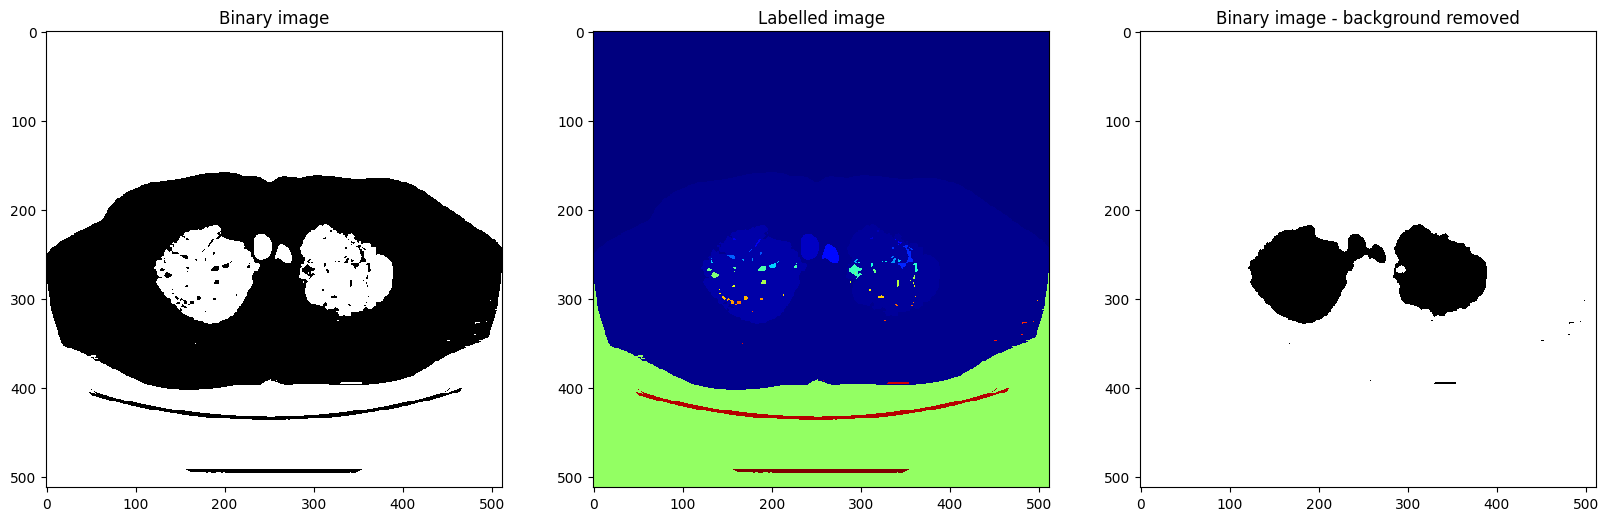

In [30]:
selem = disk(3)
closed_binary_2 = opening(binary_image_2, selem)
closed_binary_2 -= 1 #Make the image actual binary
closed_binary_2 = 1-closed_binary_2 

fig, ax = plt.subplots(1,3,figsize=(20,7))
ax[0].imshow(binary_image, cmap="binary", interpolation='nearest')
ax[1].imshow(labels, cmap="jet", interpolation='nearest')
ax[2].imshow(closed_binary_2, cmap="binary", interpolation='nearest')

ax[0].set_title("Binary image")
ax[1].set_title("Labelled image");
ax[2].set_title("Binary image - background removed");

In [16]:
def set_manual_window(hu_image, custom_center, custom_width):
    w_image = hu_image.copy()
    min_value = custom_center - (custom_width/2)
    max_value = custom_center + (custom_width/2)
    w_image[w_image < min_value] = min_value
    w_image[w_image > max_value] = max_value
    return w_image

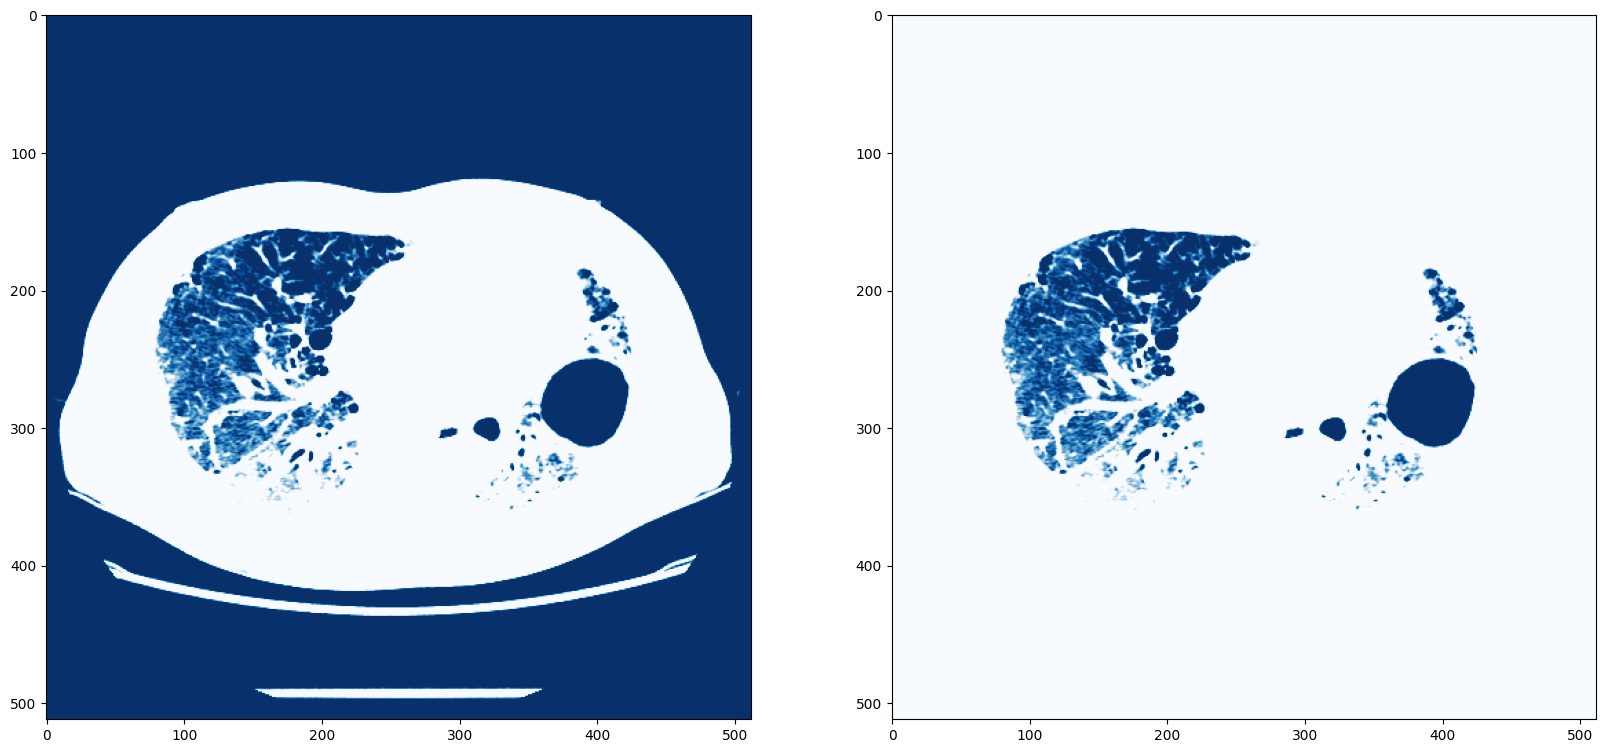

In [18]:
segmented = segment_lung_mask(np.array([hu_scans[120]]))

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(set_manual_window(hu_scans[120], -700, 255), cmap="Blues_r")
ax[1].imshow(set_manual_window(segmented[0], -700, 255), cmap="Blues_r");


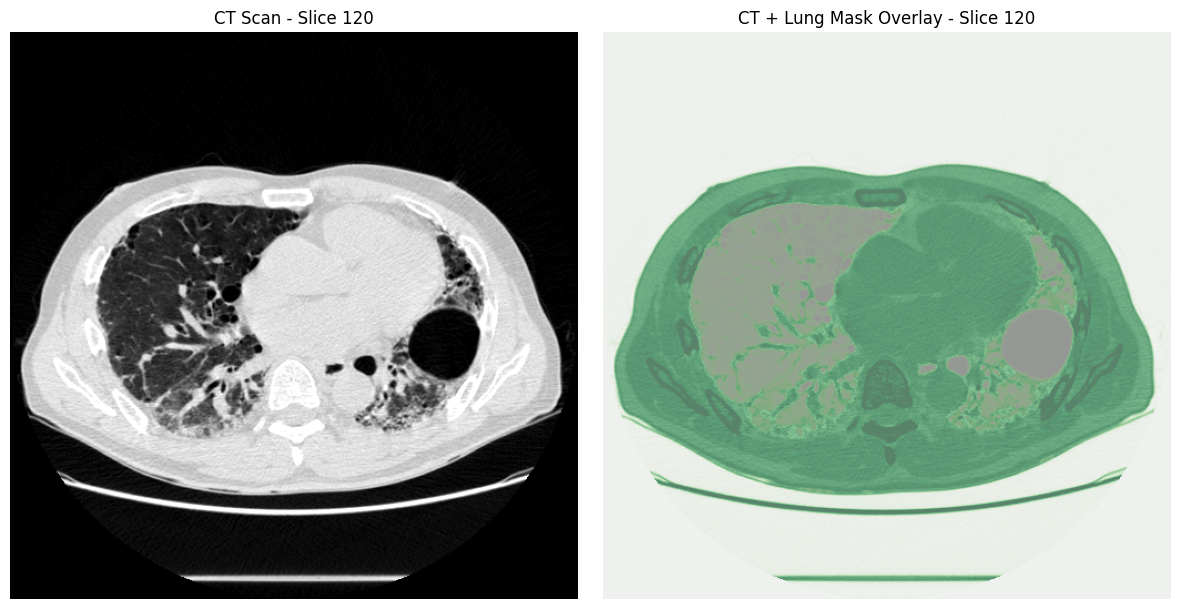

In [20]:
segmented_lungs = segment_lung_mask(hu_scans)

# Assuming hu_scans and segmented_lungs are numpy arrays of shape (slices, height, width)
ct_array = hu_scans
slice_idx = ct_array.shape[0] // 2  # middle slice

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Original CT slice ---
axes[0].imshow(ct_array[slice_idx], cmap="gray")
axes[0].set_title(f"CT Scan - Slice {slice_idx}")
axes[0].axis("off")

# --- CT + Lung Mask Overlay ---
axes[1].imshow(ct_array[slice_idx], cmap="Greens")
# Overlay mask in a bright color (e.g., red or green) with transparency
axes[1].imshow(segmented_lungs[slice_idx], cmap="gray", alpha=0.4)
axes[1].set_title(f"CT + Lung Mask Overlay - Slice {slice_idx}")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [21]:
ct_array = hu_scans  # your CT scan array

def show_slice(slice_idx):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original CT slice
    sns.heatmap(ct_array[slice_idx], cmap="gray", cbar=False, ax=axes[0])
    axes[0].set_title(f"CT Scan - Slice {slice_idx}")
    axes[0].axis("off")

    # Mask overlay
    sns.heatmap(ct_array[slice_idx], cmap="Greens", cbar=False, ax=axes[1])
    sns.heatmap(segmented_lungs[slice_idx], cmap="gray", alpha=0.5, cbar=False, ax=axes[1])
    axes[1].set_title(f"CT + Lung Mask Overlay - Slice {slice_idx}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Create slider
interact(show_slice, slice_idx=widgets.IntSlider(min=0, max=ct_array.shape[0]-1, step=1, value=ct_array.shape[0]//2));


interactive(children=(IntSlider(value=120, description='slice_idx', max=240), Output()), _dom_classes=('widget…

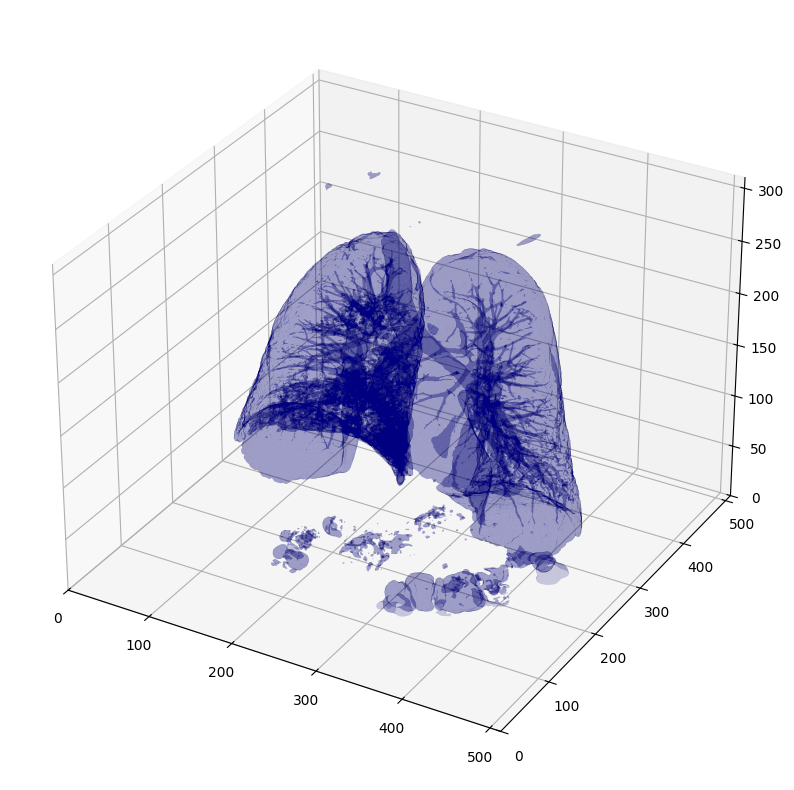

In [26]:
plot_3d(segmented_lungs, threshold=-300)